In [93]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import linear_model, naive_bayes, svm
from sklearn.metrics import accuracy_score

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from keras.utils import to_categorical

In [20]:
## splitting data into text and labels

raw_data = pd.read_table("trainingdata.txt")
raw_data.columns = ['text']
raw_data['labels'] = raw_data['text'].apply(lambda x: int(x[0]))
raw_data['text'] = raw_data['text'].apply(lambda x: x[1:])


In [21]:
raw_data.head()

,text,labels
0,champion products ch approves stock split cha...,1
1,computer terminal systems cpml completes sale...,2
2,cobanco inc cbco year net shr cts vs dlrs net...,1
3,am international inc am nd qtr jan oper shr l...,1
4,brown forman inc bfd th qtr net shr one dlr v...,1


In [24]:
raw_data['labels'].value_counts()

1    2840
2    1596
6     253
3     251
8     206
7     190
4     108
5      41
Name: labels, dtype: int64

Text(0.5,1,'Distribution of label class in raw dataset')

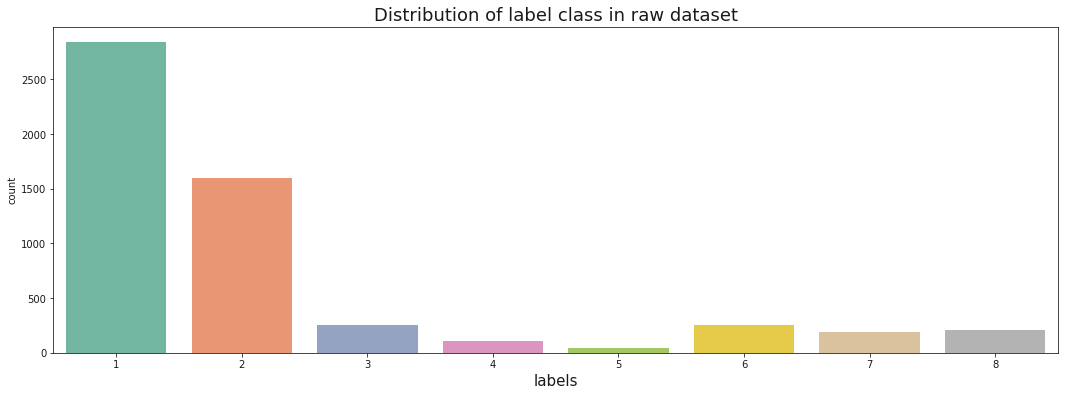

In [26]:
##distribution of labels
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('labels', data = raw_data,palette="Set2", ax = ax1)
ax1.set_xlabel("labels", size = 15)
plt.title("Distribution of label class in raw dataset", size = 18)

In [41]:
## stratified sampling to split into train and test

X_train, X_test, y_train, y_test = train_test_split(raw_data['text'], raw_data['labels'],
                                                    test_size=0.20, random_state=123, stratify = raw_data['labels'])

##### Count features

In [62]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(raw_data['text'])
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

##### tf-idf n gram features

In [63]:
### create word level idf matrix

tfidf_vect = TfidfVectorizer(analyzer='word', stop_words ='english', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(raw_data['text'])
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word',stop_words ='english', token_pattern=r'\w{1,}',
                                   ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(raw_data['text'])
X_train_tfidf_ngram =  tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram =  tfidf_vect_ngram.transform(X_test)

##### topics from lda as features

In [64]:
# train a LDA Model
lda_model = LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(X_train_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()

### Modeling

In [104]:
def train_model(classifier, feature_vector_train, labels, feature_vector_test, isNeuralNet = False):
    
    if isNeuralNet:
        y_cat = to_categorical(labels)
        classifier.fit(feature_vector_train,y_cat)
        predictions = classifier.predict(feature_vector_test)
        predictions = predictions.argmax(axis=-1)
    else:
        # fit the training dataset on the classifier
        classifier.fit(feature_vector_train, labels)
        # predict the labels on validation dataset
        predictions = classifier.predict(feature_vector_test)
    
    return accuracy_score(predictions, y_test.values)

#### Naive Bayes

In [76]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_count, y_train.values, X_test_count)
print("NB, Count Vectors: ", accuracy)

# Naive Bayes on Word Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf, y_train.values, X_test_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy)

# Naive Bayes on Ngram Level TF IDF Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), X_train_tfidf_ngram, y_train.values, X_test_tfidf_ngram)
print("NB, N-Gram Vectors: ", accuracy)

NB, Count Vectors:  0.930720145852
NB, WordLevel TF-IDF:  0.919781221513
NB, N-Gram Vectors:  0.888787602552


##### Logistic Regression

In [77]:
# logistic regression on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(), X_train_count, y_train.values, X_test_count)
print("Logistic Regression, Count Vectors: ", accuracy)

# logistic regression on Word Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), X_train_tfidf, y_train.values, X_test_tfidf)
print("Logistic Regression, WordLevel TF-IDF: ", accuracy)

# logistic regression on Ngram Level TF IDF Vectors
accuracy = train_model(linear_model.LogisticRegression(), X_train_tfidf_ngram, y_train.values, X_test_tfidf_ngram)
print("Logistic Regression, N-Gram Vectors: ", accuracy)

Logistic Regression, Count Vectors:  0.966271649954
Logistic Regression, WordLevel TF-IDF:  0.947128532361
Logistic Regression, N-Gram Vectors:  0.910665451231


##### SVM

In [79]:
# svm on Count Vectors
accuracy = train_model(svm.SVC(), X_train_count, y_train.values, X_test_count)
print("SVM, Count Vectors: ", accuracy)

# svm on Word Level TF IDF Vectors
accuracy = train_model(svm.SVC(), X_train_tfidf, y_train.values, X_test_tfidf)
print("SVM, WordLevel TF-IDF: ", accuracy)

# svm on Ngram Level TF IDF Vectors
accuracy = train_model(svm.SVC(), X_train_tfidf_ngram, y_train.values, X_test_tfidf_ngram)
print("SVM, N-Gram Vectors: ", accuracy)

SVM, Count Vectors:  0.718322698268
SVM, WordLevel TF-IDF:  0.517775752051
SVM, N-Gram Vectors:  0.517775752051


##### Shallow Neural Network

In [100]:
def create_model_architecture(input_size):
    # create input layer 
    input_layer = layers.Input((input_size, ), sparse=True)
    
    # create hidden layer
    hidden_layer = layers.Dense(100, activation="relu")(input_layer)
    
    # create output layer
    output_layer = layers.Dense(9, activation="softmax")(hidden_layer)

    classifier = models.Model(inputs = input_layer, outputs = output_layer)
    classifier.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    return classifier 

In [105]:
# NN on count vectors

classifier = create_model_architecture(X_train_count.shape[1])
accuracy = train_model(classifier, X_train_count, y_train.values, X_test_count, isNeuralNet=True)
print("NN, Count Vectors",  accuracy)

## NN on word level tf-idf vectors

classifier = create_model_architecture(X_train_tfidf.shape[1])
accuracy = train_model(classifier, X_train_tfidf, y_train.values, X_test_tfidf,isNeuralNet=True)
print("NN, WordLevel TF-IDF vectors: ", accuracy)

## NN on n-gram level tf-idf vectors

classifier = create_model_architecture(X_train_tfidf_ngram.shape[1])
accuracy = train_model(classifier, X_train_tfidf_ngram, y_train.values, X_test_tfidf_ngram,isNeuralNet=True)
print("NN, Ngram Level TF IDF Vectors:",  accuracy)

Epoch 1/1
4388/4388 [==============================] - 5s 1ms/step - loss: 0.5012
NN, Count Vectors 0.968094804011
Epoch 1/1
4388/4388 [==============================] - 1s 342us/step - loss: 1.1232
NN, WordLevel TF-IDF vectors:  0.892433910665
Epoch 1/1
4388/4388 [==============================] - 2s 342us/step - loss: 1.1328
NN, Ngram Level TF IDF Vectors: 0.867821330902


##### Convolutional Neural Networks

In [109]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('glove.6B.50d.txt')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(raw_data['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=70)
test_seq_x = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [115]:
def create_cnn():
    # Add an Input Layer
    input_layer = layers.Input((70, ))

    # Add the word embedding Layer
    embedding_layer = layers.Embedding(len(word_index) + 1, 50, weights=[embedding_matrix],
                                       trainable=False)(input_layer)
    embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)

    # Add the convolutional Layer
    conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)

    # Add the pooling Layer
    pooling_layer = layers.GlobalMaxPool1D()(conv_layer)

    # Add the output Layers
    output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
    output_layer1 = layers.Dropout(0.25)(output_layer1)
    output_layer2 = layers.Dense(9, activation="softmax")(output_layer1)

    # Compile the model
    model = models.Model(inputs=input_layer, outputs=output_layer2)
    model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy')
    
    return model

classifier = create_cnn()
accuracy = train_model(classifier, train_seq_x, y_train, test_seq_x, isNeuralNet=True)
print("CNN, Word Embeddings",  accuracy)

Epoch 1/1
4388/4388 [==============================] - 2s 570us/step - loss: 1.1050
CNN, Word Embeddings 0.781221513218


In [80]:
X_train_count.shape

(4388, 19982)

In [82]:
X_train_tfidf.shape

(4388, 5000)

In [83]:
type(X_train_count)

scipy.sparse.csr.csr_matrix

In [84]:
from scipy.sparse import hstack

x = hstack([X_train_count,X_train_tfidf])
x.shape


(4388, 24982)